In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eurosat-rgb:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F723027%2F1257124%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T001455Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D834a3293c85175d93ca7abc2f3e7ffd13fb01614fef8e499abeb0dc6d9da493764191cd0888c204ba261839f483054984f38eeb7bdb4d2a6211f61f0b541fad9fdfcb59d107006be331e2d27db0bd5fc7311241c134ef7b8eef256bb7111f3f4010e43c78653b1de5ac31a2cbabff61110620ab53aeaf7a6f256463be26d871c787921ba4e8a9acf7a7091c3bd33d3350cb17b2bd54bc560775b6e405be21a412b2db4d74a1b37d830981a09688eff094b1deb1e3ba18cd43012cabeab3ae3b9e70f54c6537f3192d8e91690fe507e819cfeaab683ed7b0c945cb182a4f50a6c2c8f8aea107198618bafbb4ff826ab529b6aa3e0f209ea7e52478230c23306ae,satellite-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1544742%2F2546969%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T001455Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d3d947844de1db8f1c4971cf630dac1e5a950e5b21bcc54958ed7a9262909d005648948200db79d11e51ea3efef5656a0afef4644f4ae87264e63cd93c23b4977141fae49a6b69f9ceb67b5e9783f3d6ce38e8cd150e0920adaa2d86f1ca4093412b92da77145b93ca53e335581a9f463c111236c009174fe7aef70ea10ae6e6b7a3009becee3a400110305a83828ea8a0b89789360a877c348eae83472600fb9940d46fd548e9f8f791d5f4aed83d4b9e87ee4b990cd8df069cbfb7caec346611965dbdc16e30c94ee1988d18c2cabb8ced7885fd1bb0e312fbf69e161f2276e9f1b5bed378701b0b20aa76a5438fd0a56989d28607792194b8cce5dffa627,nwpu-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2795415%2F4825357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T001455Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b58e6d7f562884ba690600f615225dedd44c70e64d87c26747659198c4b6d6cf0f6163cb641501b367db3104692cbb816006b1d59d2bdbe2f80520e7b4c16238464e555b90b2a0639879b74bdb12703319e97b907e92b0353acb0df5f445f09568ec9c5e850eeaeeb4d4579e2decdccac371f4a9a26acae4ee1df00c230311ee2a2415e9ae4117f8df44ea8d4ae8c66752051fed1ac88b2616c0be7f945b9b227cbf2a31fa6e9acf10934406e57b2f9db13b7f05ff59e2b224217424df4c552b56e9c2d0819df202da49fb238ac6a712a5a930adffcc2b8ba5c2646c59bb036c32f7f635e340ebcc4d8b260e23a3f0bb5869fc2f97980e78ca6967a1c6074d5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 93939673 bytes downloaded
Downloaded and uncompressed: eurosat-rgb
[==================================================] 22836290 bytes downloaded
Downloaded and uncompressed: satellite-image-classification
[==================================================] 428816154 bytes downloaded
Downloaded and uncompressed: nwpu-data-set
Data source import complete.


In [2]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import label_binarize

In [3]:
class DataLoaderX:
    def __init__(self, path, test_split, val_split, batch_size):
        self.path = path
        self.test_split = test_split
        self.val_split = val_split
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize((64, 64)),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_data(self):
        dataset = datasets.ImageFolder(root=self.path, transform=self.transform)
        test_size = int(len(dataset) * self.test_split)
        val_size = int(len(dataset) * self.val_split)
        train_size = len(dataset) - val_size - test_size
        train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
        return (
            DataLoader(train_dataset, self.batch_size, shuffle=True),
            DataLoader(test_dataset, self.batch_size, shuffle=False),
            DataLoader(val_dataset, self.batch_size, shuffle=False)
        )


In [4]:
class ModelTraining:
    def __init__(self, model, train_loader, val_loader, device, num_epochs):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.optimizer = optim.Adam(model.parameters(), lr=0.0001)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def train_epoch(self):
        self.model.to(self.device)  # Ensure the model is on the right device
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(self.train_loader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def validate_epoch(self):
        self.model.to(self.device)  # Ensure the model is on the right device
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(self.val_loader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def train(self):
        for epoch in range(self.num_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate_epoch()

            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            print(f'Epoch {epoch + 1}/{self.num_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


In [5]:
class EvaluationAndPlotting:
    @staticmethod
    def plot_training_results(train_losses, val_losses, train_accs, val_accs):
        # Plotting Training and Validation Loss
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting Training and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_roc_curve(num_classes, y_test, y_score):
        # Compute and plot the ROC curve and ROC area for each class
        fpr, tpr, roc_auc = {}, {}, {}
        y_test = label_binarize(y_test, classes=[i for i in range(num_classes)])
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    @staticmethod
    def plot_confusion_matrix(cm, classes):
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    @staticmethod
    def evaluate_and_plot(model, test_loader, device, num_classes, train_losses, train_accs, val_losses, val_accs):
        EvaluationAndPlotting.plot_training_results(train_losses, val_losses, train_accs, val_accs)

        model.eval()
        model.to(device)
        features, y_true, y_pred, y_score = [], [], [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                features.extend(outputs.cpu().detach().numpy())
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(torch.max(outputs, 1)[1].cpu().numpy())
                y_score.extend(outputs.cpu().numpy())

        # ROC curve and Confusion Matrix
        EvaluationAndPlotting.plot_roc_curve(num_classes, np.array(y_true), np.array(y_score))
        cm = confusion_matrix(y_true, y_pred)
        EvaluationAndPlotting.plot_confusion_matrix(cm, [f'Class {i}' for i in range(num_classes)])

        # t-SNE visualization
        tsne = TSNE(n_components=2, random_state=0)
        tsne_results = tsne.fit_transform(np.array(features))

        plt.figure(figsize=(8, 8))
        for i in range(num_classes):
            indices = np.where(np.array(y_true) == i)
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {i}')
        plt.legend()
        plt.title('t-SNE visualization of test features')
        plt.show()

def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, digits=2)
    print("Classification Report:")
    print(report)

In [9]:
data_path = '/kaggle/input/eurosat-rgb/2750'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 10)
data_loader = DataLoaderX(data_path, 0.15, 0.2, 16)
train_loader, test_loader, val_loader = data_loader.load_data()


In [10]:
trainer = ModelTraining(model, train_loader, val_loader, device, 30)
trainer.train()


Epoch 1/30, Train Loss: 0.5067, Train Acc: 83.42%, Val Loss: 0.2102, Val Acc: 92.98%
Epoch 2/30, Train Loss: 0.2819, Train Acc: 90.58%, Val Loss: 0.1680, Val Acc: 94.37%
Epoch 3/30, Train Loss: 0.2291, Train Acc: 92.25%, Val Loss: 0.1704, Val Acc: 94.15%
Epoch 4/30, Train Loss: 0.2019, Train Acc: 93.21%, Val Loss: 0.1393, Val Acc: 95.57%
Epoch 5/30, Train Loss: 0.1797, Train Acc: 94.01%, Val Loss: 0.1362, Val Acc: 95.48%
Epoch 6/30, Train Loss: 0.1563, Train Acc: 94.71%, Val Loss: 0.1439, Val Acc: 95.33%
Epoch 7/30, Train Loss: 0.1478, Train Acc: 95.04%, Val Loss: 0.1527, Val Acc: 94.80%
Epoch 8/30, Train Loss: 0.1326, Train Acc: 95.50%, Val Loss: 0.1190, Val Acc: 96.02%
Epoch 9/30, Train Loss: 0.1230, Train Acc: 95.78%, Val Loss: 0.1279, Val Acc: 95.59%
Epoch 10/30, Train Loss: 0.1102, Train Acc: 96.22%, Val Loss: 0.1202, Val Acc: 96.00%
Epoch 11/30, Train Loss: 0.1114, Train Acc: 96.20%, Val Loss: 0.1178, Val Acc: 96.04%
Epoch 12/30, Train Loss: 0.1059, Train Acc: 96.44%, Val Loss: 0

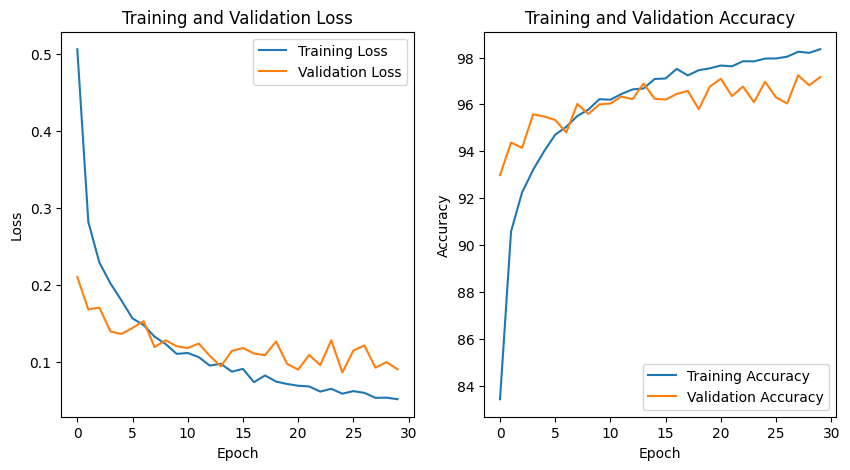

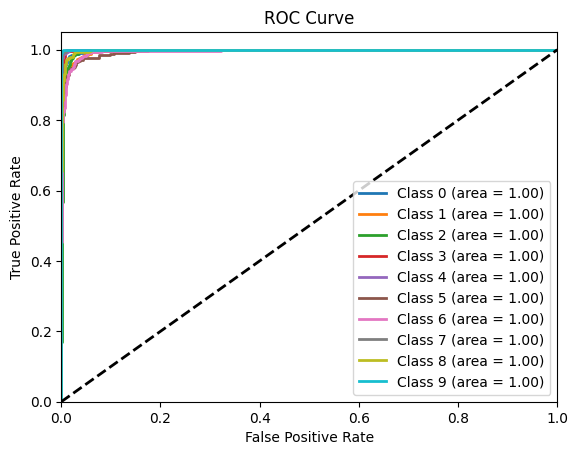

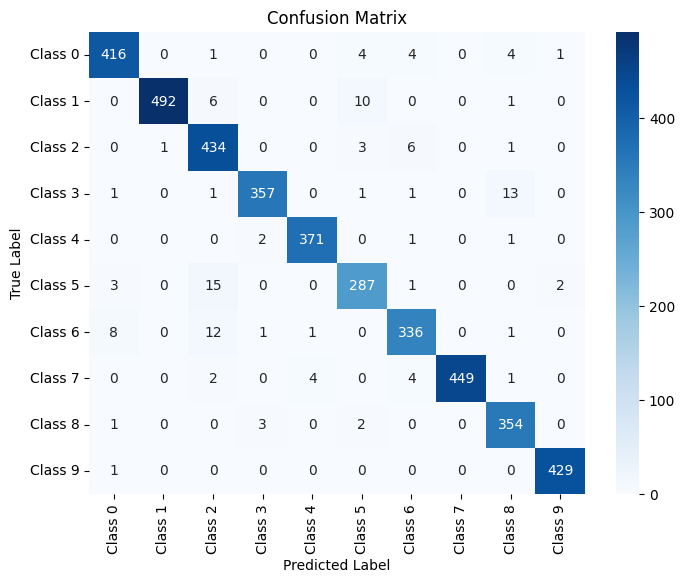

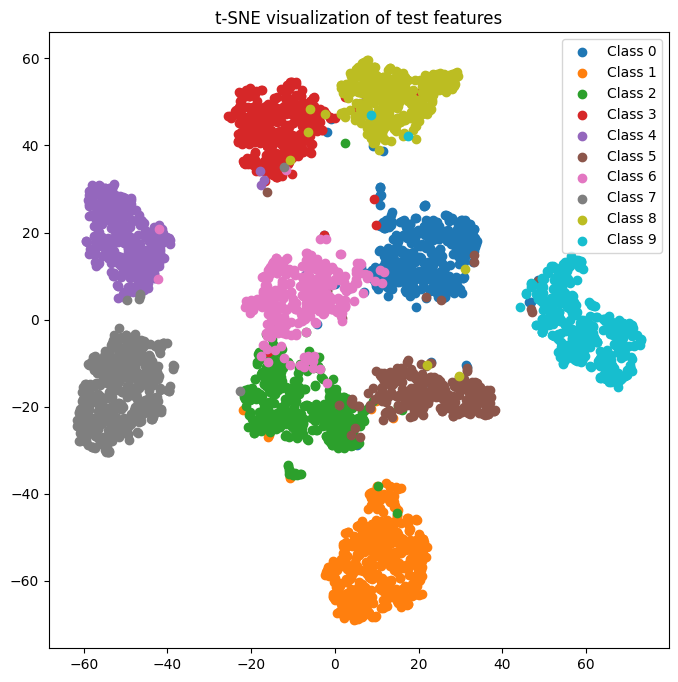

In [11]:
plotter = EvaluationAndPlotting()
plotter.evaluate_and_plot(model, test_loader, device, 10, trainer.train_losses, trainer.train_accs, trainer.val_losses, trainer.val_accs)